In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
from geopy.distance import geodesic as GD
from collections import Counter
import math
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
import matplotlib.path as mpath
from scipy.stats import gaussian_kde
from matplotlib import cm
import pandas as pd
import matplotlib as mpl
from datetime import datetime, timedelta
import xarray as xr
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.ticker as ticker
import random
plt.rcParams['font.family'] = 'Times New Roman'

# A

In [2]:
absolute_address = '../../data/Same_ET_ST_result/'

Network1_address = absolute_address + 'Network1_SC.h5'
Network2_address = absolute_address + 'Network2_SC.h5'
Network3_address = absolute_address + 'Network3_SC.h5'

f_Network1 = h5py.File(Network1_address,'r')
Network1_SC = f_Network1['SC'][:]
Network1_dis = f_Network1['dis'][:]
f_Network1.close()

f_Network2 = h5py.File(Network2_address,'r')
Network2_SC = f_Network2['SC'][:]
Network2_dis = f_Network2['dis'][:]
f_Network2.close()

f_Network3 = h5py.File(Network3_address,'r')    
Network3_SC = f_Network3['SC'][:]
Network3_dis = f_Network3['dis'][:]
f_Network3.close()
#---------------------------------------------------------------------------------

Network1_count_all = np.sum(Network1_dis > 0)
Network1_conunt_300 = np.sum(Network1_dis > 0) - np.sum(Network1_dis > 300)
Network1_dis[Network1_dis < 300] = 0

Network2_count_all = np.sum(Network2_dis > 0)
Network2_conunt_300 = np.sum(Network2_dis > 0) - np.sum(Network2_dis > 300)
Network2_dis[Network2_dis < 300] = 0

Network3_count_all = np.sum(Network3_dis > 0)
Network3_conunt_300 = np.sum(Network3_dis > 0) - np.sum(Network3_dis > 300)
Network3_dis[Network3_dis < 300] = 0

#---------------------------------------------------------------------------------

flattened_array = Network1_dis.flatten()
non_zero_elements = flattened_array[flattened_array != 0]
min_non_zero_value = np.min(non_zero_elements)
max_non_zero_value = np.max(non_zero_elements)

In [3]:
def SC_pdf(SC,dis):
    DIS = []
    for m in range(0,73,1):
        for n in range(0,144,1):
            for p in range(0,73,1):
                for q in range(0,144,1):
                    if SC[m,n,p,q] != 0: 
                        DIS.append((dis[m,n,p,q]))
                    else:
                        continue

    counter = Counter(DIS)

    dis_list = []
    count_list = []

    log_start = np.log10(min_non_zero_value) 
    log_end = np.log10(max_non_zero_value)
    log_space = np.logspace(log_start, log_end, num=40)

    for i in range (len(log_space)-1):
        dis_sum = 0
        for num, count in counter.items():
            if num > log_space[i] and num < log_space[i+1]:
                dis_sum += count
            else:
                continue
        dis_list.append(log_space[i+1])
        count_list.append(dis_sum)
    #plot
    p = [num / sum(count_list) for num in count_list]
    pdf = []
    for i in range (len(p)):
        temple_pdf = p[i]/(log_space[i+1]-log_space[i])
        pdf.append(temple_pdf)
    return dis_list,pdf 

#---------------------------------------------------------------------------
Network1_dis_list,Network1_pdf = SC_pdf(Network1_SC,Network1_dis)
Network2_dis_list,Network2_pdf = SC_pdf(Network2_SC,Network2_dis)
Network3_dis_list,Network3_pdf = SC_pdf(Network3_SC,Network3_dis)

Network1_dis_list.insert(0, 300)
Network1_pdf.insert(0,Network1_conunt_300/Network1_count_all/300)

Network2_dis_list.insert(0, 300)
Network2_pdf.insert(0,Network2_conunt_300/Network2_count_all/300)

Network3_dis_list.insert(0, 300)
Network3_pdf.insert(0,Network3_conunt_300/Network3_count_all/300)

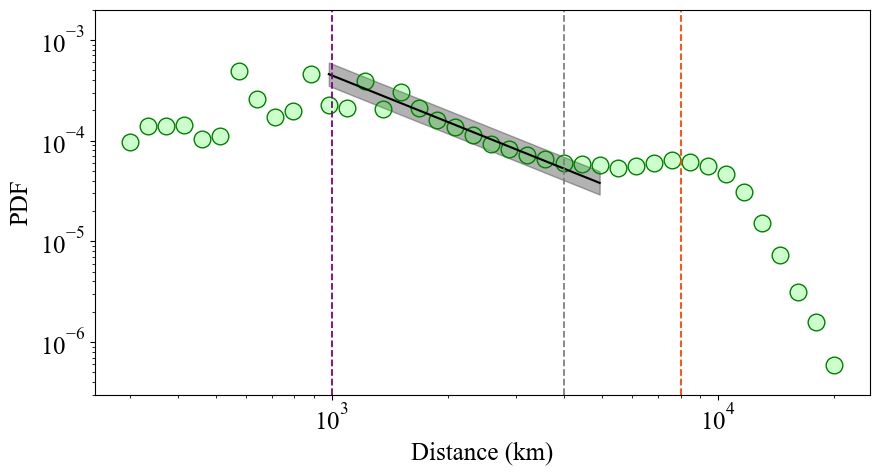

In [5]:
import seaborn as sns

fig = plt.figure(figsize=(10,5))
plt.rcParams['font.family'] = 'Times New Roman'

plt.loglog(Network1_dis_list, Network1_pdf, marker='o', linestyle='',
           markerfacecolor=(0, 1, 0, 0.2), markeredgecolor='g', label='Entire period',
           markersize=12)


x = np.array(Network1_dis_list[13:25])
y = np.array(Network1_pdf[13:25])

x_fit = np.log10(x)
y_fit = np.log10(y)
coeffs = np.polyfit(x_fit, y_fit, 1)
fit_line = np.poly1d(coeffs)

x_vals = np.logspace(np.log10(Network1_dis_list[11]), np.log10(Network1_dis_list[26]), 100)

y_vals_fit = fit_line(np.log10(x_vals))

y_fit_pred = fit_line(x_fit)
residuals = y_fit - y_fit_pred 
stderr = np.std(residuals)

confidence = 1.96 * stderr
y_upper = y_vals_fit + confidence 
y_lower = y_vals_fit - confidence  

plt.plot(x_vals, 10**fit_line(np.log10(x_vals)), color='black',linestyle='-',linewidth=1.5)
plt.fill_between(x_vals, 10**y_lower, 10**y_upper, color='black', alpha=0.3)

plt.axvline(x=4000, color='gray',linestyle='--',linewidth=1.3)
plt.axvline(x=8000, color='orangered',linestyle='--',linewidth=1.3)
plt.axvline(x=1000, color='purple',linestyle='--',linewidth=1.3)

plt.xlabel('Distance (km)',fontsize=18)
plt.ylabel('PDF',fontsize=18)
#plt.legend(loc = 'lower left',prop={'size': 15})

plt.tick_params(axis='both', labelsize=18)

plt.ylim(0.0000003, 0.002) 

#plt.savefig("FIG/FIG2/FIG2a.svg", bbox_inches='tight', dpi=400, transparent=True)
plt.show()

#fig.savefig('../image/fig2a.svg',dpi = 750,bbox_inches='tight') 

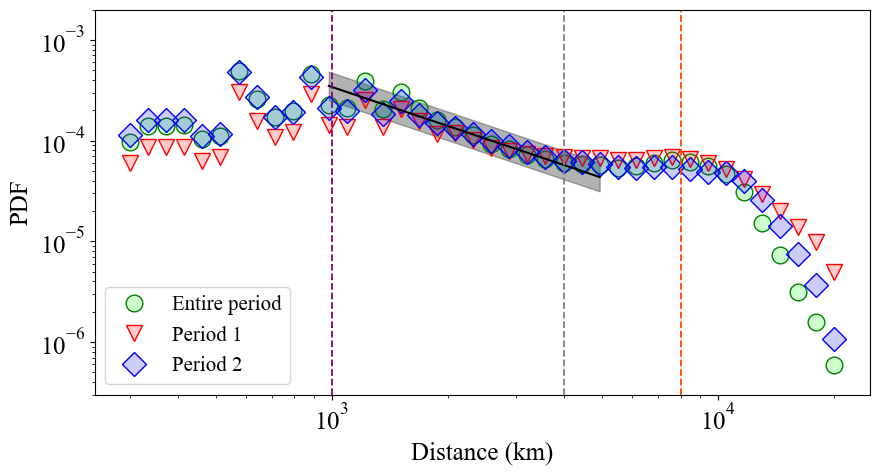

In [4]:
import seaborn as sns

fig = plt.figure(figsize=(10,5))
plt.rcParams['font.family'] = 'Times New Roman'

plt.loglog(Network1_dis_list, Network1_pdf, marker='o', linestyle='',
           markerfacecolor=(0, 1, 0, 0.2), markeredgecolor='g', label='Entire period',
           markersize=12)

plt.loglog(Network2_dis_list, Network2_pdf, marker='v', linestyle='',
           markerfacecolor=(1, 0, 0, 0.2), markeredgecolor='r', label='Period 1',
           markersize=12)

plt.loglog(Network3_dis_list, Network3_pdf, marker='D', linestyle='',
           markerfacecolor=(0, 0, 1, 0.2), markeredgecolor='b', label='Period 2',
           markersize=12)

x = np.concatenate((np.array(Network1_dis_list[13:25]),np.array(Network2_dis_list[13:25]),np.array(Network3_dis_list[13:25])))
y = np.concatenate((np.array(Network1_pdf[13:25]),np.array(Network2_pdf[13:25]),np.array(Network3_pdf[13:25])))

x_fit = np.log10(x)
y_fit = np.log10(y)
coeffs = np.polyfit(x_fit, y_fit, 1)
fit_line = np.poly1d(coeffs)

x_vals = np.logspace(np.log10(Network1_dis_list[11]), np.log10(Network1_dis_list[26]), 100)

y_vals_fit = fit_line(np.log10(x_vals))

y_fit_pred = fit_line(x_fit)
residuals = y_fit - y_fit_pred 
stderr = np.std(residuals)

confidence = 1.96 * stderr
y_upper = y_vals_fit + confidence 
y_lower = y_vals_fit - confidence  

plt.plot(x_vals, 10**fit_line(np.log10(x_vals)), color='black',linestyle='-',linewidth=1.5)
plt.fill_between(x_vals, 10**y_lower, 10**y_upper, color='black', alpha=0.3)

plt.axvline(x=4000, color='gray',linestyle='--',linewidth=1.3)
plt.axvline(x=8000, color='orangered',linestyle='--',linewidth=1.3)
plt.axvline(x=1000, color='purple',linestyle='--',linewidth=1.3)

plt.xlabel('Distance (km)',fontsize=18)
plt.ylabel('PDF',fontsize=18)
plt.legend(loc = 'lower left',prop={'size': 15})

plt.tick_params(axis='both', labelsize=18)

plt.ylim(0.0000003, 0.002) 

plt.savefig("FIG/FIG2/FIG2a.svg", bbox_inches='tight', dpi=400, transparent=True)
plt.show()

#fig.savefig('../image/fig2a.svg',dpi = 750,bbox_inches='tight') 

# B C D

In [10]:
real_address = '../../data/Same_ET_ST_result/Network3_SC.h5'

f_real = h5py.File(real_address,'r')
SC = f_real['SC'][:]
asy = f_real['asy'][:]
dis = f_real['dis'][:]
lat = f_real['lat'][:]
lon = f_real['lon'][:]
f_real.close()

asy_all_list = []
dis_all_list = []

for m in range (0,73,1):
    for n in range (0,144,1):
        for p in range (0,73,1):
            for q in range (0,144,1):

                if SC[m,n,p,q] == 0:
                    continue
                else:
                    asy_all_list.append(abs(asy[m,n,p,q]))
                    dis_all_list.append(dis[m,n,p,q])

asy_all_array = np.array(asy_all_list)
dis_all_array = np.array(dis_all_list)

dis_non_zero_indices = np.nonzero(dis_all_array)
dis_all_array = dis_all_array[dis_non_zero_indices]
asy_all_array = asy_all_array[dis_non_zero_indices]


x = np.array(list(range(0, 15001, 1000)))
y = np.array(list(np.arange(0, 0.6, 0.05)))

PDF_array = np.zeros((len(x),len(y)))

for i in range(0,len(x)-1):
    for j in range (0,len(y)-1):
        num = 0
        for k in range (0,len(dis_all_array)):
            temp_dis = dis_all_array[k]
            if temp_dis >= x[i] and temp_dis < x[i+1] and asy_all_array[k] >= y[j] and asy_all_array[k] < y[j+1]:
                num += 1
            else:
                continue
        PDF_array[i+1,j+1] = num/len(dis_all_array)

#max_indices1 = np.where(PDF_array[5:10,:] == PDF_array[5:10,:].max())[0]
#max_indices2 = np.where(PDF_array == PDF_array.max())[0]

In [6]:
asy_threshold_address = '../../data/Each_SC_threshold_result/asy_threshold.h5'
f_asy_threshold = h5py.File(asy_threshold_address,'r')
asy_threshold = f_asy_threshold['asy_threshold'][()]
f_asy_threshold.close()

C:\Users\34322\AppData\Local\Temp\ipykernel_8124\1142759264.py:8: UserWarning: Rasterization of '<matplotlib.contour.QuadContourSet object at 0x00000267E36CFE50>' will be ignored
  c1.set_rasterized(True)


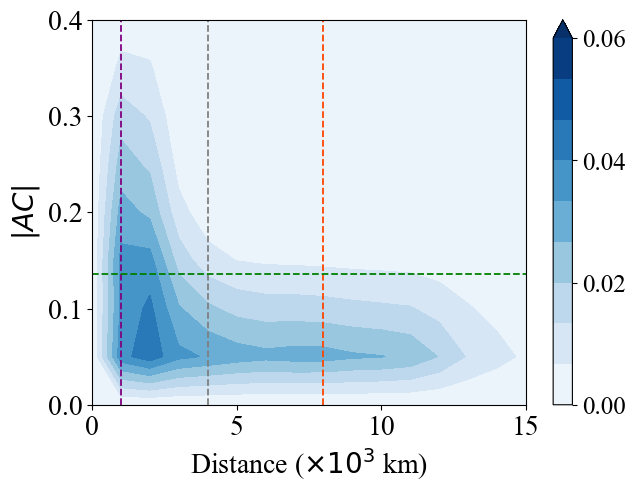

In [11]:
fig = plt.figure(figsize=(7,5))
plt.rcParams['font.family'] = 'Times New Roman'

c1=plt.contourf((x[:]),(y[:]),PDF_array.T,levels =np.linspace(0,0.06,10),extend = 'max',cmap='Blues')

cbar = plt.colorbar(format = '%.2f',ticks=[0,0.02,0.04,0.06])
cbar.ax.tick_params(labelsize=18)
c1.set_rasterized(True)

plt.ylabel(r'$| AC |$',fontsize=20)
plt.xlabel(r'Distance ($\times 10^3$ km)',fontsize=20)

plt.axvline(x=4000, color='gray',linestyle='--',linewidth=1.3)
plt.axvline(x=8000, color='orangered',linestyle='--',linewidth=1.3)
plt.axvline(x=1000, color='purple',linestyle='--',linewidth=1.3)
plt.axhline(y=asy_threshold,color='green', linestyle='--',linewidth=1.3)


#plt.text(7500, 0.21, 'SHIFT', color='orangered', fontsize=18)
#plt.annotate('', xy=(7000, 0.2), xytext=(9700, 0.2), arrowprops=dict(edgecolor='black',facecolor='orangered', width=4))
plt.xlim(0,15000)
plt.ylim(0,0.4)
plt.xticks(ticks=[0, 5000, 10000,15000], labels=['0', '5', '10','15'])
plt.tick_params(axis='both', labelsize=20)
plt.savefig("FIG/FIG2/FIG2d.svg", bbox_inches='tight', dpi=400, transparent=True)
plt.show()

#fig.savefig('../image/fig2e.svg',dpi = 400,bbox_inches='tight') 